<a href="https://colab.research.google.com/github/AbdoAlkayal/Machine_Learning/blob/main/Image_Classification(Rock%2CPaper%2CScissors).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, losses, optimizers
import pandas as pd

tf.config.run_functions_eagerly(True)  # 🔥 Enables eager execution


# Load dataset and show info
print("🔄 Loading dataset...")
(train_all, test), ds_info = tfds.load('rock_paper_scissors', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)
print("✅ Dataset loaded.")
print(f"🧾 Number of training examples: {ds_info.splits['train'].num_examples}")
print(f"🧾 Number of test examples: {ds_info.splits['test'].num_examples}")
print(f"📁 Label names: {ds_info.features['label'].names}")

🔄 Loading dataset...
✅ Dataset loaded.
🧾 Number of training examples: 2520
🧾 Number of test examples: 372
📁 Label names: ['rock', 'paper', 'scissors']


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [4]:
# Split training set: 90% for training, 10% for validation
print("🔀 Splitting dataset into training (90%) and validation (10%)...")
train_all = tfds.load('rock_paper_scissors', split='train[:90%]', as_supervised=True)
val_all = tfds.load('rock_paper_scissors', split='train[90%:]', as_supervised=True)

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, [300, 300])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply preprocessing
print("🧼 Preprocessing and batching datasets...")
train = train_all.map(preprocess).cache().shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
val = val_all.map(preprocess).cache().batch(32).prefetch(tf.data.AUTOTUNE)
test = test.map(preprocess).cache().batch(32).prefetch(tf.data.AUTOTUNE)

# Dataset summary
print(f"📦 Training dataset - batches: {train.cardinality().numpy()}")
print(f"📦 Validation dataset - batches: {val.cardinality().numpy()}")


🔀 Splitting dataset into training (90%) and validation (10%)...
🧼 Preprocessing and batching datasets...
📦 Training dataset - batches: 71
📦 Validation dataset - batches: 8


In [5]:
# Define optimizers
optimizer_configs = {
    "SGD": optimizers.SGD(learning_rate=0.01),
    "SGD_Momentum": optimizers.SGD(learning_rate=0.01, momentum=0.9),
    "Adagrad": optimizers.Adagrad(learning_rate=0.01),
    "RMSProp": optimizers.RMSprop(learning_rate=0.001),
    "Adam": optimizers.Adam(learning_rate=0.001),
}

In [6]:
def build_mlp_model():
    return models.Sequential([
        layers.Flatten(input_shape=(300, 300, 3)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(3, activation='softmax')  # Output layer for 3 classes
    ])
mlp_models = {}  # Dictionary to store trained MLP models
mlp_histories = {}
# Train and evaluate each optimizer
for name, opt in optimizer_configs.items():
    print(f"\n🧠 Building and training model with optimizer: {name}")
    model = build_mlp_model()
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print(f"🚀 Training with {name}...")
    histor= model.fit(train, validation_data=val, epochs=4)
    mlp_models[name] = model  # Save the trained model
    mlp_histories[name] = histor.history
    print(f"✅ Finished training with {name}.")



🧠 Building and training model with optimizer: SGD


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🚀 Training with SGD...
Epoch 1/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.3405 - loss: 68.7177 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 2/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3322 - loss: 1.0989 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.3443 - loss: 1.0985 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 4/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.3464 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
✅ Finished training with SGD.

🧠 Building and training model with optimizer: SGD_Momentum
🚀 Training with SGD_Momentum...
Epoch 1/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.3029 - loss: 1031.0289 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 2/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.3370 - loss: 1.0990 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.3266 - loss: 1.0989 - val_accu

In [7]:
# Dictionary to store evaluation results
mlp_test_results = {}

# Evaluate each stored model
for name, model in mlp_models.items():
    print(f"\n🔍 Evaluating MLP model with {name} optimizer...")
    loss, accuracy = model.evaluate(test, verbose=1)
    mlp_test_results[name] = {'Loss': loss, 'Accuracy': accuracy}
    print(f"📊 {name} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Compare all results in a summary table
print("\n📋 Evaluation Summary:")
print(f"{'Optimizer':<15} {'Loss':<10} {'Accuracy'}")
print("-" * 35)
for name, metrics in mlp_test_results.items():
    print(f"{name:<15} {metrics['Loss']:<10.4f} {metrics['Accuracy']:.4f}")




🔍 Evaluating MLP model with SGD optimizer...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.3250 - loss: 1.0987
📊 SGD - Loss: 1.0986, Accuracy: 0.3333

🔍 Evaluating MLP model with SGD_Momentum optimizer...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3418 - loss: 1.0989
📊 SGD_Momentum - Loss: 1.0989, Accuracy: 0.3333

🔍 Evaluating MLP model with Adagrad optimizer...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3332 - loss: 1.5739
📊 Adagrad - Loss: 1.5856, Accuracy: 0.3333

🔍 Evaluating MLP model with RMSProp optimizer...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5545 - loss: 1.0020
📊 RMSProp - Loss: 1.0073, Accuracy: 0.5511

🔍 Evaluating MLP model with Adam optimizer...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5094 - loss: 13.2099
📊 Adam - Loss: 13.9759, Accuracy: 0.4839

📋 Evaluation Summary:
Optimizer       Loss       Accuracy
-----------------------------------
SGD             1.0986     0.3333
SGD_Momentum    1.0989     0.3333
Adag

In [8]:
# Define optimizers
optimizer_configs = {
    "SGD": optimizers.SGD(learning_rate=0.01),
    "SGD_Momentum": optimizers.SGD(learning_rate=0.01, momentum=0.9),
    "Adagrad": optimizers.Adagrad(learning_rate=0.01),
    "RMSProp": optimizers.RMSprop(learning_rate=0.001),
    "Adam": optimizers.Adam(learning_rate=0.001),
}

In [9]:
# CNN model builder function
def build_cnn_model():
    return models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(3, activation='softmax')  # 3 output classes
    ])
cnn_models = {} # Dictionary to store models if not already stored
cnn_histories = {}
# Train and evaluate CNN model with each optimizer
for name, opt in optimizer_configs.items():
    print(f"\n🧠 Building CNN model with optimizer: {name}")
    model= build_cnn_model()
    model.compile( optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print(f"🚀 Training CNN model using {name}...")
    histor = model.fit(train, validation_data=val, epochs=4, verbose=1)
    cnn_models[name] = model # Save trained model
    cnn_histories[name] = histor.history
    print(f"✅ Training complete for {name}")



🧠 Building CNN model with optimizer: SGD
🚀 Training CNN model using SGD...
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 218ms/step - accuracy: 0.3924 - loss: 1.0957 - val_accuracy: 0.4405 - val_loss: 1.0472
Epoch 2/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 198ms/step - accuracy: 0.4975 - loss: 1.0098 - val_accuracy: 0.6389 - val_loss: 0.8810
Epoch 3/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 200ms/step - accuracy: 0.6273 - loss: 0.8636 - val_accuracy: 0.6429 - val_loss: 0.7203
Epoch 4/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 200ms/step - accuracy: 0.7440 - loss: 0.6465 - val_accuracy: 0.9246 - val_loss: 0.3664
✅ Training complete for SGD

🧠 Building CNN model with optimizer: SGD_Momentum
🚀 Training CNN model using SGD_Momentum...
Epoch 1/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - accuracy: 0.3919 - loss: 1.1035 - val_accuracy: 0.3770 - val_loss: 1.0841
Epoch 2/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - accuracy: 0.6206 - loss: 0.8031 - val_accuracy: 0.9405 - val_loss: 0.2158
Epoch 3/4
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.9582 - loss: 0.1335 - val_accuracy: 0.9960 - val_loss:

In [10]:
# Dictionary to store evaluation results
cnn_test_results = {}

# Evaluate each model on the test dataset
for name, model in cnn_models.items():
    print(f"\n🔍 Evaluating model trained with {name}...")
    loss, accuracy = model.evaluate(test, verbose=1)
    cnn_test_results[name] = {'Loss': loss, 'Accuracy': accuracy}
    print(f"📊 {name} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Compare all results in a summary table
print("\n📋 Evaluation Summary:")
print(f"{'Optimizer':<15} {'Loss':<10} {'Accuracy'}")
print("-" * 35)
for name, metrics in cnn_test_results.items():
    print(f"{name:<15} {metrics['Loss']:<10.4f} {metrics['Accuracy']:.4f}")




🔍 Evaluating model trained with SGD...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.6892 - loss: 0.7209
📊 SGD - Loss: 0.7525, Accuracy: 0.6747

🔍 Evaluating model trained with SGD_Momentum...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7600 - loss: 0.7829
📊 SGD_Momentum - Loss: 0.7834, Accuracy: 0.7500

🔍 Evaluating model trained with Adagrad...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8752 - loss: 0.4070
📊 Adagrad - Loss: 0.4156, Accuracy: 0.8683

🔍 Evaluating model trained with RMSProp...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7112 - loss: 1.4318
📊 RMSProp - Loss: 1.6021, Accuracy: 0.7124

🔍 Evaluating model trained with Adam...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7010 - loss: 1.5572
📊 Adam - Loss: 1.6681, Accuracy: 0.6935

📋 Evaluation Summary:
Optimizer       Loss       Accuracy
-----------------------------------
SGD             0.7525     0.6747
SGD_Momentum    0.7834     0.7500
Adagrad         0.4156     0.8683
RM

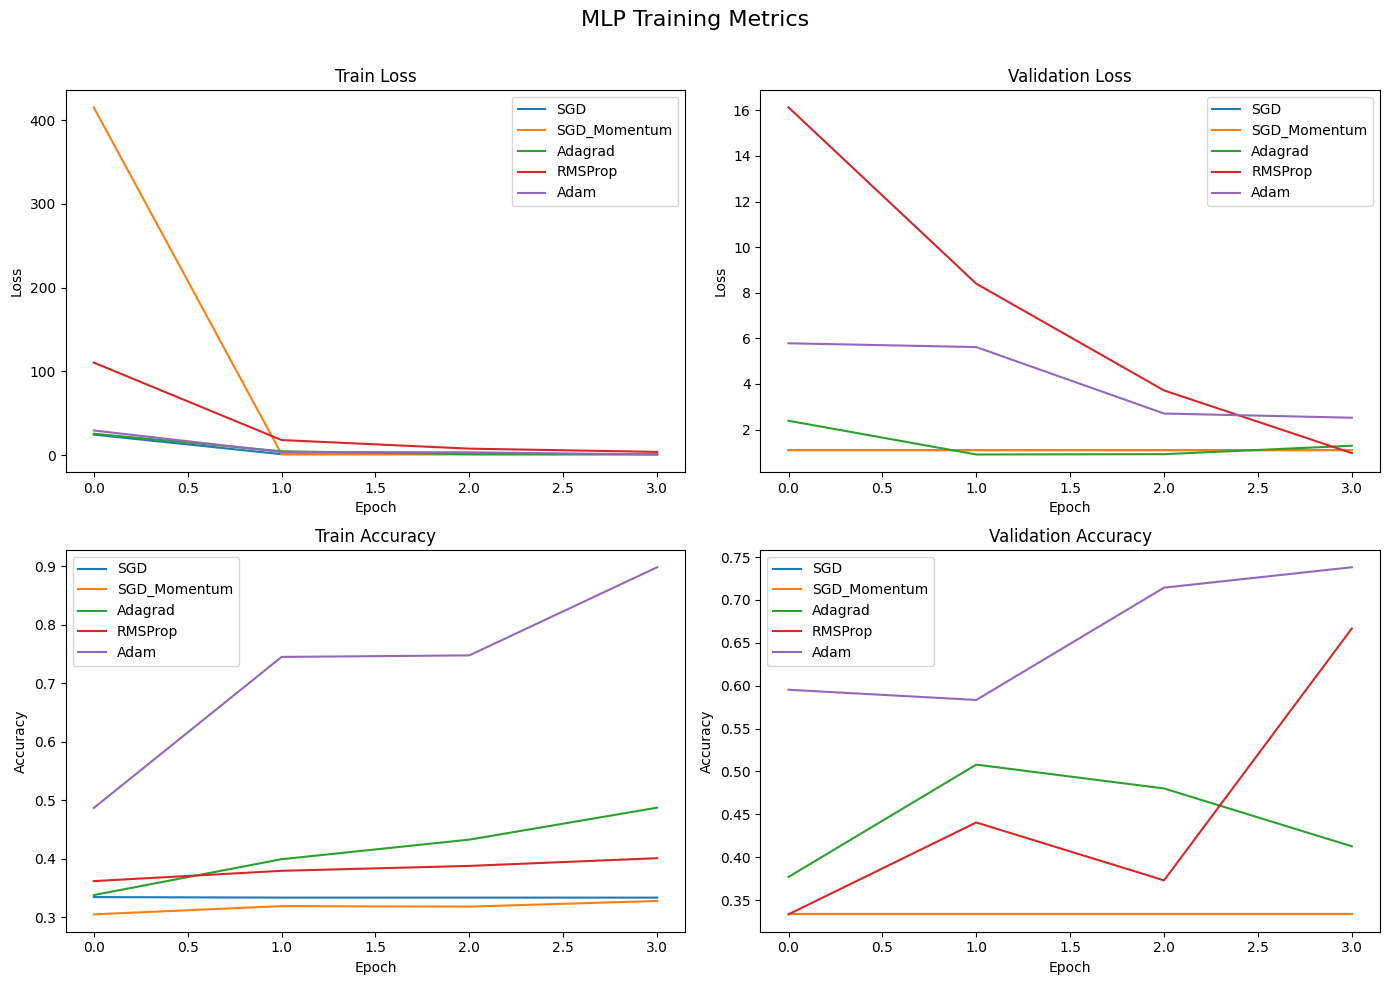

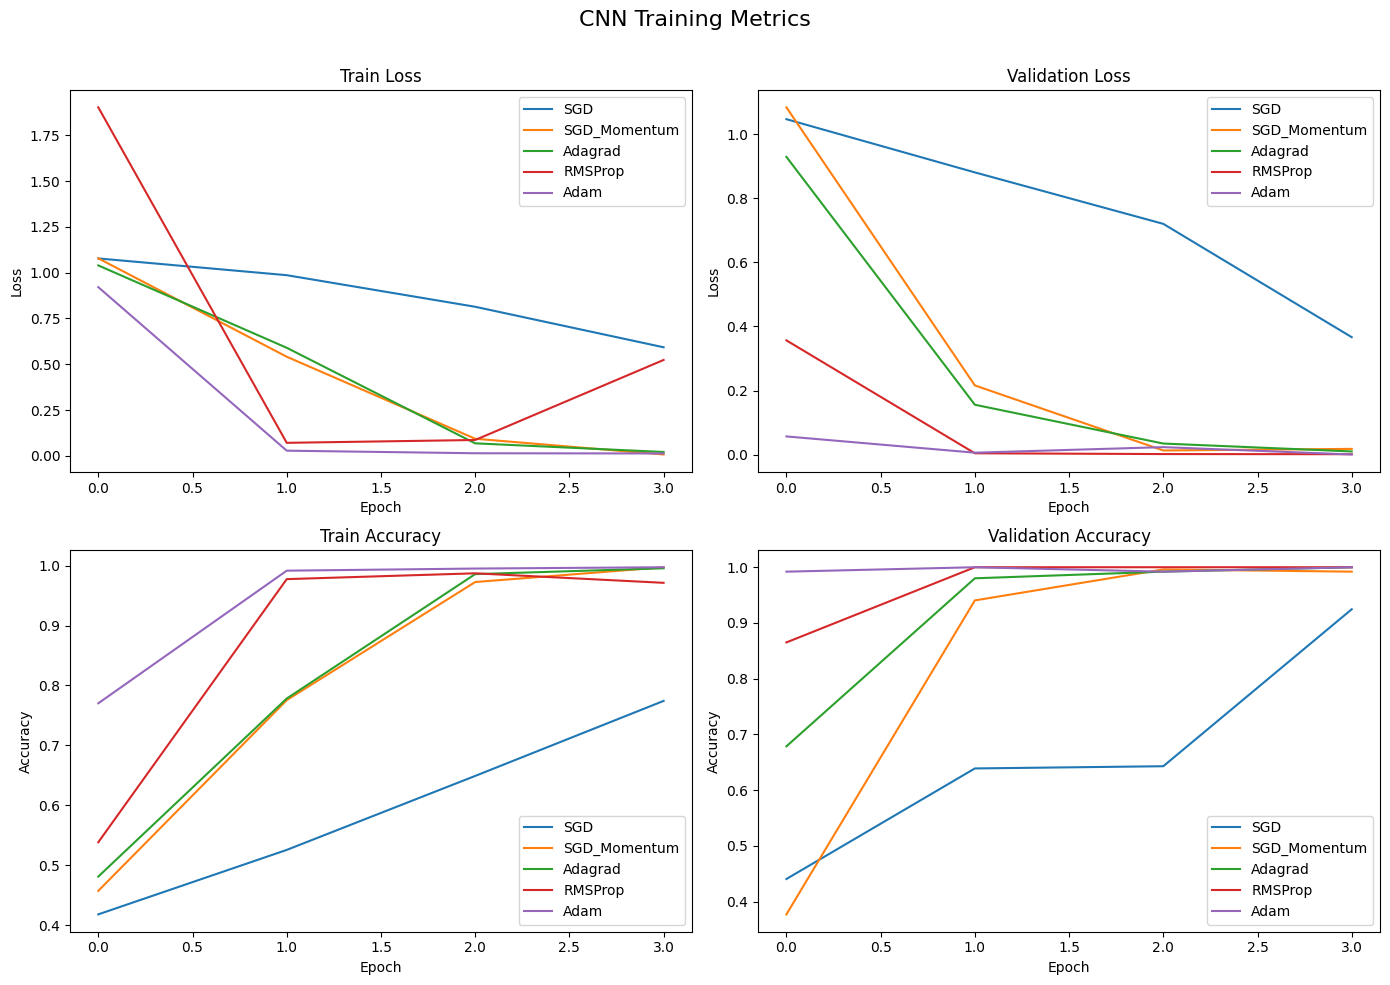

In [11]:
def plot_metrics(histories, model_type):
    optimizers = list(histories.keys())

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{model_type} Training Metrics', fontsize=16)

    # Plot 1: Training Loss
    for opt in optimizers:
        axs[0, 0].plot(histories[opt]['loss'], label=opt)
    axs[0, 0].set_title('Train Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Plot 2: Validation Loss
    for opt in optimizers:
        axs[0, 1].plot(histories[opt]['val_loss'], label=opt)
    axs[0, 1].set_title('Validation Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()

    # Plot 3: Training Accuracy
    for opt in optimizers:
        axs[1, 0].plot(histories[opt]['accuracy'], label=opt)
    axs[1, 0].set_title('Train Accuracy')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].legend()

    # Plot 4: Validation Accuracy
    for opt in optimizers:
        axs[1, 1].plot(histories[opt]['val_accuracy'], label=opt)
    axs[1, 1].set_title('Validation Accuracy')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# 🔍 Plot for MLP
plot_metrics(mlp_histories, "MLP")

# 🔍 Plot for CNN
plot_metrics(cnn_histories, "CNN")


In [14]:
# Extract final training and validation metrics for both MLP and CNN models
final_results = []

# MLP models results
for name, history in mlp_histories.items():
    final_train_loss = history['loss'][-1]
    final_train_accuracy = history['accuracy'][-1]
    final_val_loss = history['val_loss'][-1]
    final_val_accuracy = history['val_accuracy'][-1]
    final_results.append({
        'Model': f"MLP_{name}",
        'Train Loss': final_train_loss,
        'Train Accuracy': final_train_accuracy,
        'Val Loss': final_val_loss,
        'Val Accuracy': final_val_accuracy
    })

# CNN models results
for name, history in cnn_histories.items():
    final_train_loss = history['loss'][-1]
    final_train_accuracy = history['accuracy'][-1]
    final_val_loss = history['val_loss'][-1]
    final_val_accuracy = history['val_accuracy'][-1]
    final_results.append({
        'Model': f"CNN_{name}",
        'Train Loss': final_train_loss,
        'Train Accuracy': final_train_accuracy,
        'Val Loss': final_val_loss,
        'Val Accuracy': final_val_accuracy
    })

# Create DataFrame
df = pd.DataFrame(final_results)

# Print the table
print("\n📋 Final Evaluation Results for MLP and CNN Models:")
print(df)



📋 Final Evaluation Results for MLP and CNN Models:
              Model  Train Loss  Train Accuracy  Val Loss  Val Accuracy
0           MLP_SGD    1.098729        0.333333  1.098616      0.333333
1  MLP_SGD_Momentum    1.099202        0.327601  1.098931      0.333333
2       MLP_Adagrad    1.022456        0.487213  1.290819      0.412698
3       MLP_RMSProp    3.835326        0.400794  0.968220      0.666667
4          MLP_Adam    0.766488        0.898589  2.519795      0.738095
5           CNN_SGD    0.592634        0.774250  0.366441      0.924603
6  CNN_SGD_Momentum    0.007567        0.997355  0.017713      0.992063
7       CNN_Adagrad    0.021183        0.995591  0.009703      1.000000
8       CNN_RMSProp    0.523410        0.971340  0.001120      1.000000
9          CNN_Adam    0.013121        0.997355  0.000222      1.000000
